In [1]:
import berrylib.util
berrylib.util.setup_nb()

# The Berry model

## Notation
* $d$ is the number of arms in the trial
* $\hat{I}$ is the sample information matrix.
* $\mathbf{y}$ is the *vector* count data.
* $\mathbf{n}$ is the *vector* number of patients per arm.
* $\mathbf{p}$ is the *vector* probability-space odds per arm
* $\mathbf{\theta}$ is the *vector* logit-space true offsets
* $\mathbf{p_1}$ is the *vector* of targeted treatment effects.
* $\hat{\mathbf{\theta}}$ is the *vector* logit-space observed offsets.
* $\mu$ is the mean of the sharing distribution ($\theta$ prior)
* $\sigma$ is the standard deviation of the sharing distribution ($\theta$ prior)
* $\mu_0 = -1.34$ is the mean of the $\mu$ prior.
* $S = 10$ is the std dev of the $\mu$ prior.


## The basic model

\begin{align}
\mathbf{y} &\sim Binomial( \mathbf{p}, \mathbf{n})\\
\mathbf{p} &= \mathrm{expit}(\mathbf{\theta} + logit(\mathbf{p_1}))\\
\mathbf{\theta} &\sim N(\mu, \sigma^2)\\
\mu &\sim N(\mu_0, S^2)\\
\sigma^2 &\sim InvGamma(0.0005, 0.000005)\\

P(y, \theta, \sigma^2) &= P(\sigma^2) P(\theta|\sigma^2) P(y|\theta)
\end{align}

The model in the paper considers four arms.

There are two version of the hypotheses and critical values which we'll call the "Figure 1/2 design" and the "simulation design".

### Figure 1/2 design:

Hypotheses:
\begin{align}
p_0&=0.1\\
p_1&=0.3\\
p_{mid} &= \frac{p_0 + p_1}{2}
\end{align}

Early futility:
\begin{align}
Pr(p_i > p_{mid}) < 0.05
\end{align}

Final analysis:
\begin{align}
Pr(p_i > p_0) > 0.85
\end{align}

### Simulation design for Figures 3 and up

Hypotheses:
\begin{align}
p_0&=[0.05, 0.05, 0.1, 0.2]\\
p_1&=[0.2, 0.2, 0.3, 0.4]\\
p_{mid} &= \frac{p_0 + p_1}{2}
\end{align}

Early futility and success:
\begin{align}
Pr(p_i > p_{mid}) < 0.05\\
Pr(p_i > p_{mid}) > 0.90
\end{align}

Final analysis:
\begin{align}
Pr(p_i > p_0) > [0.82, 0.82, 0.85, 0.9]
\end{align}


In [2]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
from scipy.special import logit

n_i = np.array([20, 20, 35, 35])
# Try running with this parameter set! You'll find INLA does a lot worse. Exercise: Why?
# y_i = np.array([0, 1, 9, 10], dtype=np.float64)
y_i = np.array([1, 1, 9, 10], dtype=np.float64)

mu_0 = -1.34
mu_sig_sq = 100.0
logit_p1 = logit(0.3)

# INLA

## Section 1: compute $p(\sigma^2|y)$

### 1.0, analytically integrate out $\mu$:

\begin{align}
P(\mu) &= N(\mu_0, S^2)\\
P(\theta|\mu_0, \sigma^2) &= N(\mu_0, \sigma^2)\\
P(\theta|\sigma^2) &= P(\theta|\mu_0, \sigma^2, S^2) =  N(\mu_0, \sigma^2 I + S^2 J)
\end{align}

where J is the matrix of all 1s (everywhere, not just the diagonal!) and I is the identity matrix.

### 1.1: Construct $\sigma^2$ quadrature rule

and compute values dependent only on $\sigma^2$:
* precision matrix for $p(\theta | \sigma^2)$, often referred to as $Q$: this is the inverse covariance.
* determinant of precision matrix
* values of the prior.

In [3]:
sigN = 90
sigma2_rule = berrylib.util.log_gauss_rule(sigN, 1e-6, 1e3)
arms = np.arange(4)

# See above, cov = sigma2 * I + mu_sig_sq2
cov = np.full((sigN, 4, 4), mu_sig_sq)
cov[:, arms, arms] += sigma2_rule.pts[:, None]

precQ = np.linalg.inv(cov)
precQdet = np.linalg.det(precQ)
log_prior = scipy.stats.invgamma.logpdf(sigma2_rule.pts, 0.0005, scale=0.000005)

### 1.2: find the maximum of $p(\theta, y, \sigma^2)$

for each value of $\sigma^2$.

The goal here is to construct a Gaussian approximation at the maximum. To find the maximum, we use Newton's method. In the process of finding that maximum, we also find the Hessian at the maximum, which is the quadratic term in our Taylor series. Because the Taylor series is at the maximum, the first order term is zero. 

Now, because we're working with a log density, a quadratic approximation transforms into a Gaussian approximation in probability space after exponentiation! Gaussians are easy to integrate and we will take advantage of this fact later on.

In [4]:
tol = 1e-4
theta_max = np.zeros((sigN, 4))
for i in range(100):
    theta_m0 = theta_max - mu_0
    theta_adj = theta_max + logit_p1
    grad = (
        -np.sum(precQ * theta_m0[:, None, :], axis=-1)
        + y_i
        - (n_i * np.exp(theta_adj) / (np.exp(theta_adj) + 1))
    )
    hess = -precQ.copy()
    hess[:, arms, arms] -= n_i * np.exp(theta_adj) / ((np.exp(theta_adj) + 1) ** 2)
    step = -np.linalg.solve(hess, grad)
    theta_max += step

    if np.max(np.linalg.norm(step, axis=-1)) < tol:
        print('number of newton iterations', i)
        break

number of newton iterations 5


### 1.3 Laplace approximation for calculating $p(\sigma^2|y)$

Let's derive the expression!

Factorize the joint distribution: 
\begin{align}
\log p(y, \theta, \sigma^2) = \log p(\theta | y, \sigma^2) + \log p(\sigma^2|y) + \log p(y) \\ 
\end{align}

Drop the $\log p(y)$ term because it's just a constant offset (or multiplicative offset in probability space rather than log space)) and we plan to re-normalize our probabality distribution at the end. This transforms our statement from equality to proportionality. Also, the statement above is true for any particular choice of $\theta$. So, we will choose the maximizer identified in the previous section:

\begin{align}
\log p(\sigma^2|y) \propto \big[\log p(y, \theta, \sigma^2) - \log p(\theta | y, \sigma^2)\big]_{\theta = \theta_0(\sigma^2)}
\end{align}

Here $\propto$ is used to say that a statement is true up to an additive constant. This is a little different from the normal meaning of up to a multiplicative constant, but is the more appropriate meaning in log space.

Next, we write out the second term on the right hand side using the definition of a conditional:

\begin{align}
p(\theta_0 | \sigma^2, y) = \frac{p(\theta_0, y, \sigma^2)}{\int \exp(\log p(\theta, y, \sigma^2)) d\theta}
\end{align}

The denominator looks a little funny right? Why haven't we collapsed the $\exp \log$? Written this way, the Gaussian integral is clear when we replace $\log p(\theta, y, \sigma^2)$ with the quadratic approximation in the last section.

The integral of a multivariate Gaussian we want is:
\begin{align}
\int \exp[f(\theta)] d\theta \approx \exp[f(\theta_0)](2\pi)^{n/2}\bigg| -Hf(\theta_0))\bigg|^{-1/2}
\end{align}
where $\theta_0$ is the maximizer, $Hf(\theta_0)$ is the Hessian and $n$ is the dimension of $\theta$. The bars around the (matrix) Hessian indicate a determinant. 

Plugging into the conditional formula above and taking a logarithm:

\begin{align}
\log p(\theta_0 | \sigma^2, y) = \log p(\theta_0, y, \sigma^2) - \log p(\theta_0, y, \sigma^2) - \log ((2\pi)^{n/2}) + \frac{1}{2} \log \bigg| -Hf(\theta_0))\bigg|
\end{align}

The first two terms cancel. And we can drop the third term because it's just a constant offset. The result is:
\begin{align}
\log p(\theta_0 | \sigma^2, y) \propto \frac{1}{2} \log \bigg| -Hf(\theta_0))\bigg|
\end{align}

Remember that $\propto$ is used to say that a statement is true up to an additive constant.

Returning to the goal of calculating $p(\sigma^2 | y)$, we use our factorization from before:
\begin{align}
\log p(\sigma^2|y) \propto \big[\log p(y, \theta, \sigma^2) - \log p(\theta | y, \sigma^2)\big]_{\theta = \theta_0(\sigma^2)}\\
\log p(\sigma^2|y) \propto \log p(y, \theta_0, \sigma^2) - \frac{1}{2} \log \bigg| -Hf(\theta_0))\bigg|
\end{align}

This final formula is the one we implement in the short and sweet code below and give us the **the posterior of the hyperparameter**.

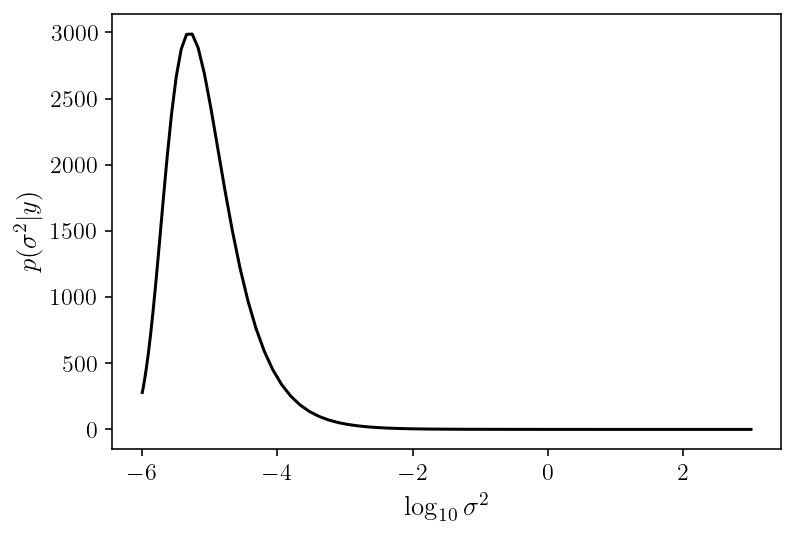

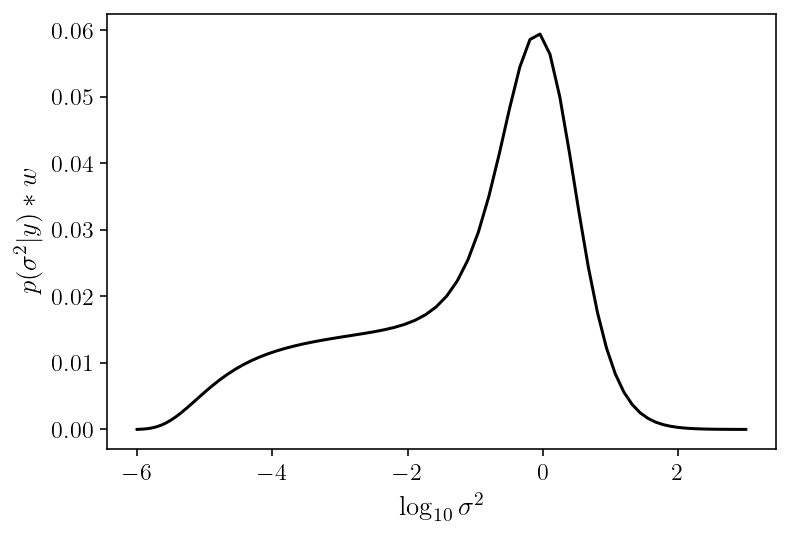

In [5]:
# 1) Calculate the log joint density.
theta_m0 = theta_max - mu_0
theta_adj = theta_max + logit_p1
logjoint = (
    -0.5 * np.einsum("...i,...ij,...j", theta_m0, precQ, theta_m0)
    + 0.5 * np.log(precQdet)
    + np.sum(theta_adj * y_i - n_i * np.log(np.exp(theta_adj) + 1), axis=-1)
    + log_prior
)

# 2) Calculate log p(\sigma^2 | y) according to the formula above.
log_sigma2_post = logjoint - 0.5 * np.log(np.linalg.det(-hess))

# 3) Transform from log to probability space.
sigma2_post = np.exp(log_sigma2_post)

# 4) Normalize by the integral of p(\sigma^2 | y) to make this a true probability distribution!
sigma2_post /= np.sum(sigma2_post * sigma2_rule.wts)

# Plot the result! This is the posterior distribution of the hyperparameter.
plt.plot(np.log10(sigma2_rule.pts), sigma2_post, 'k-')
plt.xlabel('$\log_{10} \sigma^2$')
plt.ylabel('$p(\sigma^2 | y)$')
plt.show()

# We also plot the posterior multiplied by the integration weights. This can be
# useful since it weights the density by which portion are most "influential".
plt.plot(np.log10(sigma2_rule.pts), sigma2_post * sigma2_rule.wts, 'k-')
plt.xlabel('$\log_{10} \sigma^2$')
plt.ylabel('$p(\sigma^2 | y) * w$')
plt.show()

## Section 2: computing latent variable marginals: $p(\theta_i | y)$


In [6]:
arm_idx = 0
ti_N = 61
ti_rule = berrylib.util.simpson_rule(ti_N, -6.0, 2.0)

### 2.0: Do it with full numerical integration (slow)


In [7]:
import berrylib.fast_inla as fast_inla
import berrylib.quadrature as quadrature

fi = fast_inla.FastINLA(sigma2_n=sigN, n_arms=4)
quad_p_ti_g_y = quadrature.integrate(
    fi, y_i, n_i, fixed_arm_dim=arm_idx, fixed_arm_values=ti_rule.pts,
    n_theta=11
)
quad_p_ti_g_y /= np.sum(quad_p_ti_g_y * ti_rule.wts)

/Users/tbent/.mambaforge/envs/imprint/lib/python3.10/site-packages/jax/_src/lib/__init__.py:33: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


CPU times: user 30.6 s, sys: 434 ms, total: 31.1 s
Wall time: 30.2 s


### 2.1: Gaussian approximation of $p(\theta_i|y, \sigma^2)$

When we calculated the posterior of the hyperparameters above in section 1.3, we developed a multi-variate normal approximation for $p(\theta|y, \sigma^2)$. We can re-use this approximation now to compute $p(\theta_i | y)$. 

The final step is to evaluate at a range of $\theta_i$ and then integrate over $\sigma^2$.

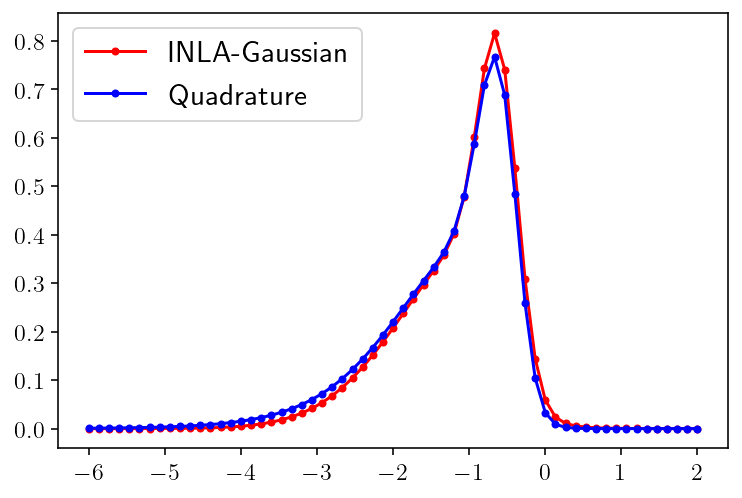

In [8]:
theta_i_sigma = np.sqrt(np.diagonal(-np.linalg.inv(hess), axis1=1, axis2=2))
theta_i_mu = theta_max
gaussian_pdf = scipy.stats.norm.pdf(
    ti_rule.pts[:, None],
    theta_i_mu[None, :, arm_idx],
    theta_i_sigma[None, :, arm_idx],
)
gaussian_p_ti_g_y = np.sum(
    gaussian_pdf * sigma2_post * sigma2_rule.wts[None, :], axis=1
)

plt.plot(ti_rule.pts, gaussian_p_ti_g_y, "r-o", markersize=3, label="INLA-Gaussian")
plt.plot(ti_rule.pts, quad_p_ti_g_y, "b-o", markersize=3, label="Quadrature")
plt.legend()
plt.show()

### 2.1a: redo it for all the arms:

0


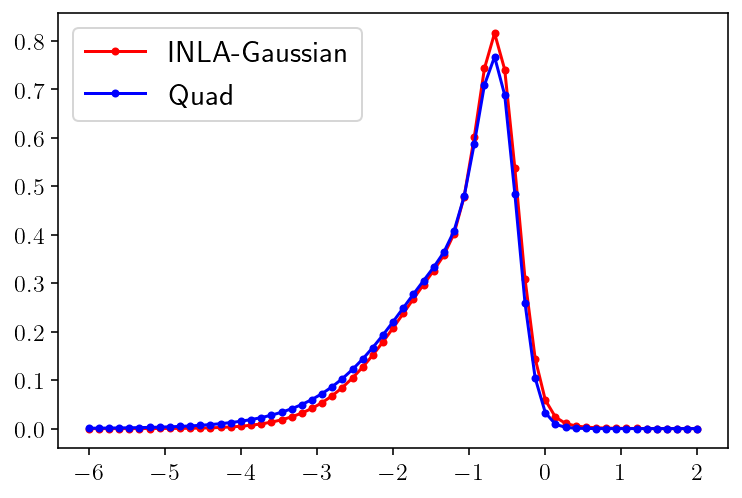

1


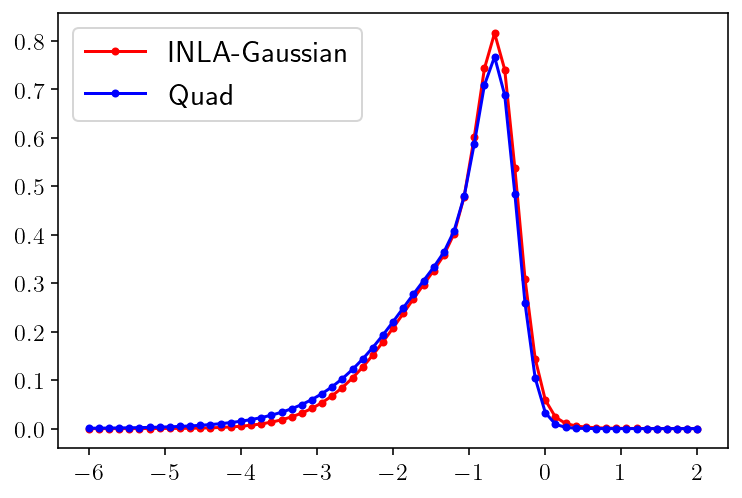

2


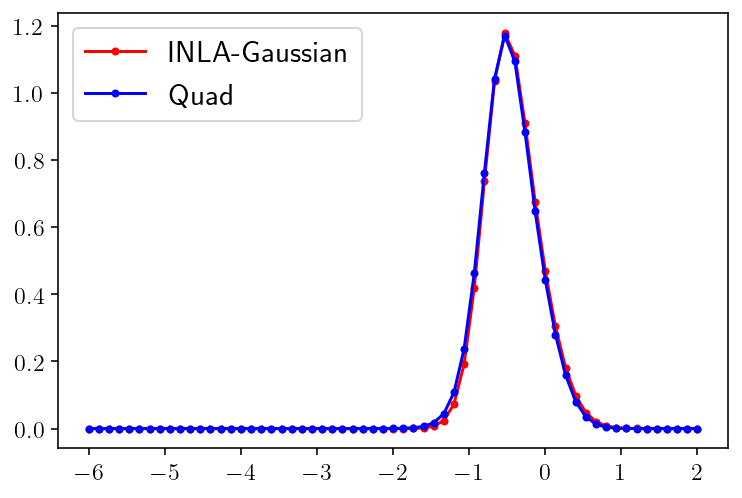

3


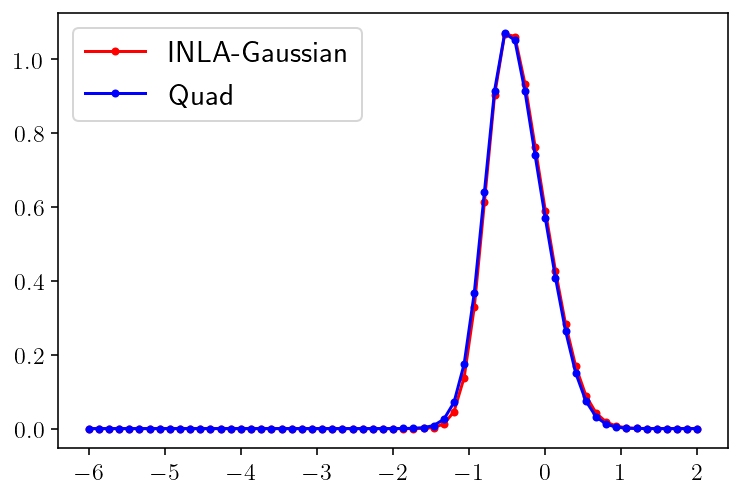

In [10]:
for arm_idx in range(4):
    print(arm_idx)
    quad_p_ti_g_y = quadrature.integrate(
        fi,
        y_i,
        n_i,
        fixed_arm_dim=arm_idx,
        fixed_arm_values=ti_rule.pts,
    )
    quad_p_ti_g_y /= np.sum(quad_p_ti_g_y * ti_rule.wts)

    theta_i_sigma = np.sqrt(np.diagonal(-np.linalg.inv(hess), axis1=1, axis2=2))
    theta_i_mu = theta_max
    gaussian_pdf = scipy.stats.norm.pdf(
        ti_rule.pts[:, None],
        theta_i_mu[None, :, arm_idx],
        theta_i_sigma[None, :, arm_idx],
    )
    gaussian_p_ti_g_y = np.sum(
        gaussian_pdf * sigma2_post * sigma2_rule.wts[None, :], axis=1
    )

    plt.plot(ti_rule.pts, gaussian_p_ti_g_y, "r-o", markersize=3, label="INLA-Gaussian")
    plt.plot(ti_rule.pts, quad_p_ti_g_y, "b-o", markersize=3, label="Quad")
    plt.legend()
    plt.show()


### 2.2: Laplace approximation of $p(\theta_i|y, \sigma^2)$

Instead of assuming $p(\theta_i|y, \sigma^2)$ is Gaussian, we will compute it using the same Laplace approximation method that we used to compute $p(\sigma^2|y)$. That is:
* we optimize over $\mathbf{\theta}_{-i}$ - the list of $\theta$ indices that are not equal to $i$.
* Then we assume that $p(\mathbf{\theta}_{-i})$ is Gaussian and use that fact to compute the Gaussian integral in the denominator as before.


In [13]:
y_tiled = np.tile(y_i[None,:], (ti_rule.pts.shape[0], 1))
n_tiled = np.tile(n_i[None,:], (ti_rule.pts.shape[0], 1))
ti_pts_tiled = np.tile(ti_rule.pts[:, None], (1, fi.sigma2_n)) 

ti_max, ti_hess_inv = fi.optimize_mode(y_tiled, n_tiled, fixed_arm_dim=arm_idx, fixed_arm_values=ti_pts_tiled)
ti_logjoint = fi.log_joint(y_tiled, n_tiled, ti_max)

ti_post = np.exp(ti_logjoint + 0.5 * np.log(np.linalg.det(-ti_hess_inv)))
ti_post /= np.sum(ti_post * ti_rule.wts[:, None], axis=0)
laplace_p_ti_g_y = np.sum(ti_post * sigma2_post * sigma2_rule.wts, axis=1)

plt.figure(figsize=(7, 4))
plt.plot(ti_rule.pts, gaussian_p_ti_g_y, "r-o", markersize=3, label="INLA-Gaussian")
plt.plot(ti_rule.pts, laplace_p_ti_g_y, "k-o", markersize=3, label="INLA-Laplace")
plt.plot(ti_rule.pts, quad_p_ti_g_y, "b-o", markersize=3, label="Quad")
plt.legend()
plt.show()

# Dirty Bayes

## Section 1: Approximating the posterior conditional on hyperparameters

### Step #1, exact, integrate out $\mu$, just use normal distribution conjugacy

\begin{align}
P(\mu) &= N(\mu_0, S^2)\\
P(\theta|\mu, \sigma^2) &= N(\mu_0, \sigma^2)\\
P(\theta|\sigma^2) &= P(\theta|\mu_0, \sigma^2, S^2) =  N(\mu_0, \sigma^2 I + S^2 J)
\end{align}

where J is the matrix of all 1s (everywhere, not just the diagonal!) and I is the identity matrix.

### Step #2, the important approximation!! Binomial asymptotically is Normal 

\begin{align}
\mathbf{y} \sim N(\mathbf{\theta} + logit(\mathbf{p_1}), I^{-1})
\end{align}

### Step #3, introduce data to approximate likelihood:

\begin{align}
I^{-1} \approx \hat{I}^{-1} = \hat{p} (1 - \hat{p}) / n\\
P(y|\theta) = N(\mathbf{\theta} + \mathbf{p_1}, I^{-1}) \approx N(\hat{\mathbf{\theta}} + \mathbf{p_1}, \hat{I}^{-1})\\
\end{align}

### Step #4, combine the two Gaussians $P(y|\theta)$ and $P(\theta|\sigma^2)$:

\begin{align}
P(\theta|y,\sigma^2) = \frac{P(\theta|\sigma^2)P(y|\theta)}{P(y|\sigma^2)}
\end{align}

Using Gaussian posterior conjugacy: 
\begin{align}
\theta|y, \sigma^2 \sim N(\mu_d, \Sigma_d)\\
\mu_d = ...\\
\Sigma_d = ...\\
\end{align}

## Section 2: Integration over hyperparameters
### Step #5: integrate out $\sigma^2$

\begin{align}
P(\theta|y) = \int P(\theta| y, \sigma^2)P(\sigma^2|y) d\sigma^2
\end{align}

### Step #6: manipulate $\sigma^2$ posterior

By definition of conditional prob:
\begin{align}
P(\sigma^2|y) = \frac{P(\sigma^2, y)}{P(y)}
\end{align}

### Step #7: computing the joint distribution $P(\sigma^2, y)$

\begin{align}
P(\sigma^2, y) &= P(\sigma^2)P(y|\sigma^2)\\
y|\sigma^2 &\sim N(\mu, \hat{I}^{-1} + \Sigma_{\sigma^2})
\end{align}
Also, recall the prior:
\begin{align}
\sigma^2 &\sim InvGamma(0.0005, 0.000005)\\
\end{align}

### Step #8: compute $P(y)$ posterior

Once we have computed the joint probability $P(\sigma^2, y)$, the denominator/marginal/data-prior $P(y)$ can be easily computed by numerically integrating over $\sigma^2$.

### Step #9: actually do the integral from step #5.

TODO: this should be updated to correct for the fact that we compute relevant quantities like exceedance probabilities before integrating.
Because this integral is done numerically, we now have a mixture of Gaussians. The mean and variance of a weighted mixture of gaussians is a well-known formula: INSERT FORMULA HERE.


In [16]:
phat = y_i / n_i
thetahat = logit(phat) - logit_p1
# Step 3 above
sample_I = n_i * phat * (1 - phat)

mu_post = np.empty((sigN,4))
sigma_post = np.empty((sigN, 4))
joint_sigma2_y = np.empty(sigN)
for i, sig2 in enumerate(sigma2_rule.pts):
    # Prior covariance for the thetas
    # Step 1 above!
    S_0 = np.diag(np.repeat(sig2, 4)) + mu_sig_sq

    # Prior precision matrix for the thetas
    # Step 1
    V_0 = np.linalg.inv(S_0)

    # Formula for conjugate prior/posterior
    # Step 2/4:
    precision_posterior = V_0 + np.diag(sample_I)

    # The covariance is the inverse of the precision.
    # Step 2/4:
    Sigma_posterior = np.linalg.inv(precision_posterior)
    sigma_post[i] = np.diag(Sigma_posterior)

    # Further conjugate prior solution.
    # Step 2/4:
    mu_post[i] = Sigma_posterior @ (sample_I * thetahat + (V_0 * mu_0).sum(axis=-1))

    # Step 6/7: compute P(\sigma^2, y)
    prior = scipy.stats.invgamma.pdf(sig2, 0.0005, scale=0.000005)
    y_given_sig2 = scipy.stats.multivariate_normal.pdf(
        thetahat,
        np.repeat(-1.34, 4),
        (np.diag(sample_I ** -1) + np.diag(np.repeat(sig2, 4)) + mu_sig_sq),
    )
    joint_sigma2_y[i] = prior * y_given_sig2

In [17]:
# Integrate over sigma2 to find the normalization factor for p(\sigma^2 | y)
py = np.sum(joint_sigma2_y * sigma2_rule.wts)
sigma2_given_y = joint_sigma2_y / py

# Computing exceedance

For each $\sigma^2$ value, we have a separate multivariate gaussian approximation. But we want to understand the arm marginal distributions, that is: $p(\theta_i | y)$. To get from $p(\theta_i | \sigma^2, y)$ to $p(\theta_i | y)$, we need to integrate over $\sigma^2$.  Each of these gaussians has some integration weight according to $p(\sigma^2|y) * w$. So, the final arm marginal is a mixture of Gaussians. 

An important point is that we need to compute exceedance probabilities before integrating. While we could compute a single multivariate normal approximation to our mixture of Gaussians (as suggested in "INLA from Scratch"), this single approximation will not provide us nearly the accuracy in exceedance probability as we get from computing exceedance and then integrating second.

\begin{align}
P(\theta_i > T| y) = \int P(\theta_i > T | \sigma^2, y) p(\sigma^2|y) d\sigma^2
\end{align}

In [18]:
# remember that theta = logit(p) - logit(p1)
p_threshold = 0.1
theta_threshold = logit(p_threshold) - logit_p1

# integration weights
weights = sigma2_given_y * sigma2_rule.wts
exceedance_db = np.sum(
    (
        1.0
        - scipy.stats.norm.cdf(
            theta_threshold, mu_post, sigma_post
        )
    )
    * weights[:, None],
    axis=0
)
exceedance_db

array([0.87727121, 0.87727121, 1.        , 1.        ])

In [19]:
inla_sigma = np.sqrt(np.diagonal(-np.linalg.inv(hess), axis1=1, axis2=2))
inla_mu = theta_max
exceedance_inla = np.sum(
    (
        1.0
        - scipy.stats.norm.cdf(
            theta_threshold, inla_mu, inla_sigma
        )
    )
    * weights[:, None],
    axis=0
)
exceedance_inla

array([0.83748942, 0.83748942, 0.99820646, 0.99898751])